## Compute feature importance in test set

In [7]:

from models.setting import ETA_EXP, NODE_DEPTH_INDEX, TASK, DATA_PATH, MODEL_PATH, RESULT_PATH, LOAD_MODEL, LOAD_MODEL_PATH, CLASS_IMBALANCE_WT, LAMBDA_ETA, DAGGER_NUM_ITER, DAGGER_NUM_TRAIN_EXAMPLES_PER_ITER, DAGGER_NUM_VALID_EXAMPLES_PER_ITER, BB_MAX_STEPS

TASK = 'antenna_selection'


if TASK == 'antenna_selection':
    from antenna_selection.observation import Observation, LinearObservation
    from antenna_selection.as_bb_par import ASBBenv as Environment, DefaultBranchingPolicy, solve_bb

elif TASK == 'robust_beamforming':
    from robust_beamforming.observation import Observation, LinearObservation
    from robust_beamforming.bb import BBenv as Environment, DefaultBranchingPolicy, solve_bb
    
elif TASK == 'single_cast_beamforming':
    from single_beamforming.observation import Observation, LinearObservation
    from single_beamforming.acr_bb import ACRBBenv as Environment, DefaultBranchingPolicy, solve_bb

elif TASK == 'single_group_as_bm':
    from single_group_as_bm.observation import Observation, LinearObservation
    from single_group_as_bm.bb import BBenv as Environment, DefaultBranchingPolicy, solve_bb

import torch
import torch.nn as nn
import numpy as np

from models.gnn_policy import GNNPolicy, GNNNodeSelectionPolicy
from tqdm import tqdm
import torch_geometric
import gzip
import pickle
from models.gnn_dataset import GraphNodeDataset, instance_generator
from pathlib import Path
from models.gnn_dataset import get_graph_from_obs
import shutil
import time
import os
import random


from models.fcn_policy import FCNNodeSelectionLinearPolicy, FCNNodeDataset
from torch.utils.data import DataLoader
from models.dagger_collect_data_multiprocess import DataCollect
import csv
from torch.distributions import Exponential
from models.feature_importance import *


CLASS_IMBALANCE_WEIGHT = 11

torch.set_num_threads(1)

np.random.seed(300)
N, M, max_ant = 8, 6, 4
train_filepath = os.path.join(DATA_PATH, 'N={},M={},L={}/'.format(N,M,max_ant)) 
policy_type = 'gnn'

# train instances should be a list of tuples (H, w_opt) 
NodeDataset = GraphNodeDataset
DataLoader = torch_geometric.data.DataLoader
NodePolicy = GNNNodeSelectionPolicy

# training data is inside policy_data and the oracle solutions are inside oracle_data 
train_filepath = os.path.join(train_filepath, 'policy_data')
valid_filepath = os.path.join(train_filepath, 'valid_policy_data')


instances = instance_generator(M, N)

# Parameters for training
DEVICE = 'cuda'

learning_rate = 0.0001
train_epochs = 10
batch_size = 128

policy = NodePolicy()
policy = policy.to(DEVICE)
optimizer = torch.optim.Adam(policy.parameters(), lr=learning_rate)

model_folderpath = os.path.join(MODEL_PATH, 'gnn_exp')

if not os.path.isdir(model_folderpath):
    Path(model_folderpath).mkdir(exist_ok = True)

train_loss = 0
valid_loss = 0
train_acc = 0
valid_acc = 0
train_fpr = 0
train_fnr = 0
valid_fpr = 0
valid_fnr = 0

model_filepath = os.path.join(model_folderpath, 'gnn_exp.model')
torch.save(policy.eval().to('cpu').state_dict(), model_filepath)

train_files = [str(path) for path in Path(train_filepath).glob('sample_*.pkl')]            
# valid_files = [str(path) for path in Path(valid_filepath).glob('sample_*.pkl')]
random.shuffle(train_files)
valid_files = train_files[int(0.8*len(train_files)):]
train_files = train_files[:int(0.8*len(train_files))]

train_data = NodeDataset(train_files)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

valid_data = NodeDataset(valid_files)
valid_loader = DataLoader(valid_data, batch_size=128, shuffle=True)

policy = policy.train().to(DEVICE)

# training stage
total_data = 0
for _ in tqdm(range(train_epochs)):
    mean_loss = 0
    mean_acc = 0
    n_samples_processed = 0
    targets_list = torch.Tensor([]).to(DEVICE)
    preds_list = torch.Tensor([]).to(DEVICE)
    for batch_data in (train_loader):
        batch, target = batch_data
        batch = batch.to(DEVICE)
        target = target.to(DEVICE)*1

        if policy_type == 'gnn':
            batch_size = batch.num_graphs
            num_vars = int(batch.variable_features.shape[0]/batch_size)
            wts = torch.tensor([batch.variable_features[i*num_vars, NODE_DEPTH_INDEX] for i in range(batch_size)], dtype=torch.float32)
        else:
            batch_size = batch.shape[0] 
            wts = batch[:,-25]

        wts = 1/wts
        wts = wts.to(DEVICE)

        # print([batch.variable_features[i*num_vars, 9].item() for i in range(batch_size)], wts, target)
        wts = ((target)*CLASS_IMBALANCE_WT + 1)*wts                   
        out = policy(batch, batch_size)
        bce = nn.BCELoss(weight=wts)   

        try:
            F_w = bce(out.squeeze(), target.to(torch.float).squeeze())
        except:
            F_w = bce(out, target.to(torch.float))
        loss = F_w 

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        predicted_bestindex = (out>0.5)*1
        accuracy = sum(predicted_bestindex.reshape(-1) == target)

        targets_list = torch.cat((targets_list, target))
        preds_list = torch.cat((preds_list, predicted_bestindex))

        mean_loss += loss.item() * batch_size
        mean_acc += float(accuracy)
        n_samples_processed += batch_size
    total_data = n_samples_processed
    stacked = torch.stack((targets_list, preds_list.squeeze()), dim=1).to(torch.int)
    cmt = torch.zeros(2,2,dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    print(cmt)
    precision = cmt[1,1]/(cmt[0,1]+cmt[1,1])
    recall = cmt[1,1]/(cmt[1,0]+cmt[1,1])

    train_fpr = cmt[0,1]/(cmt[0,0] + cmt[0,1])
    train_fnr = cmt[1,0]/(cmt[1,0] + cmt[1,1])

    mean_acc = 2* (precision*recall)/(precision+recall)
    mean_loss /= n_samples_processed
    print("Train: precision:{}, recall:{}, f1-score:{}, loss: {}, acc: {}".format(precision, recall, mean_acc, mean_loss, mean_acc))
train_loss = mean_loss
train_acc = mean_acc




 10%|█         | 1/10 [00:35<05:18, 35.34s/it]

tensor([[   0, 6039],
        [   0, 2858]])
Train: precision:0.321231871843338, recall:1.0, f1-score:0.48626115918159485, loss: 0.5570855543253541, acc: 0.48626115918159485


 20%|██        | 2/10 [00:39<02:15, 16.99s/it]

tensor([[2022, 4017],
        [  82, 2776]])
Train: precision:0.40865597128868103, recall:0.9713085889816284, f1-score:0.5752771496772766, loss: 0.3139634993560826, acc: 0.5752771496772766


 30%|███       | 3/10 [00:43<01:17, 11.02s/it]

tensor([[3485, 2554],
        [ 121, 2737]])
Train: precision:0.5172935128211975, recall:0.9576627016067505, f1-score:0.671738862991333, loss: 0.2696914782705127, acc: 0.671738862991333


 40%|████      | 4/10 [00:47<00:49,  8.23s/it]

tensor([[3546, 2493],
        [ 108, 2750]])
Train: precision:0.5245088934898376, recall:0.9622113108634949, f1-score:0.678928554058075, loss: 0.25644197600791196, acc: 0.678928554058075


 50%|█████     | 5/10 [00:51<00:33,  6.70s/it]

tensor([[3498, 2541],
        [  99, 2759]])
Train: precision:0.5205660462379456, recall:0.9653604030609131, f1-score:0.6763913035392761, loss: 0.2510608049729064, acc: 0.6763913035392761


 60%|██████    | 6/10 [00:55<00:23,  5.76s/it]

tensor([[3540, 2499],
        [  95, 2763]])
Train: precision:0.5250855088233948, recall:0.966759979724884, f1-score:0.6805418729782104, loss: 0.24402047342345382, acc: 0.6805418729782104


 70%|███████   | 7/10 [00:59<00:15,  5.17s/it]

tensor([[3537, 2502],
        [  86, 2772]])
Train: precision:0.5255972743034363, recall:0.9699090123176575, f1-score:0.6817511320114136, loss: 0.24545829573568098, acc: 0.6817511320114136


 80%|████████  | 8/10 [01:03<00:09,  4.73s/it]

tensor([[3539, 2500],
        [  83, 2775]])
Train: precision:0.5260663628578186, recall:0.9709587097167969, f1-score:0.6824050545692444, loss: 0.2363141415473436, acc: 0.6824050545692444


 90%|█████████ | 9/10 [01:06<00:04,  4.46s/it]

tensor([[3559, 2480],
        [  66, 2792]])
Train: precision:0.5295903086662292, recall:0.976906955242157, f1-score:0.6868388652801514, loss: 0.23242185206792187, acc: 0.6868388652801514


100%|██████████| 10/10 [01:10<00:00,  7.07s/it]

tensor([[3540, 2499],
        [  69, 2789]])
Train: precision:0.5274205803871155, recall:0.9758572578430176, f1-score:0.6847532391548157, loss: 0.22945784689389387, acc: 0.6847532391548157


In [8]:
# validation 
np.random.seed(1)

feature_map = {
                'Z' : (0, [0]),
                'Z_FEASIBLE' : (0, [1]),
                'Z_MASK' : (0, [2]),
                'W_POWER' : (0, [3]),
                'H' : (1, [0,1,2]),
                'W_INCUMBENT' : (1, [3,4,5]),
                'W_SOLUTION' : (1, [6,7,8]),
                'L_GLOBAL' : (2, [0]),
                'U_GLOBAL' : (2, [1]),
                'PROXIMITY_GLOBAL_U' : (2, [2]),
                'DIRECT_GAIN' : (2, [3]),
                'AGGREGATE_INTERFERENCE' : (2,[4]),
                'NODE_DEPTH' : (2,[5]),
                'L_LOCAL': (2, [6]),
                'U_LOCAL': (2, [7])
    
}


feature_names = ['antenna', 'edge', 'user']
feature_sizes = [9, 3, 6]

results = {}
results['true'] = run_validation(valid_loader, policy, device=DEVICE)
feature_importance = {}

ins = RandomizedDataset(valid_data)
for key in feature_map:
    feature_name = feature_names[feature_map[key][0]]
    feature_indices = feature_map[key][1]
    random_dataset = ins.randomize_feature(feature_name=feature_name , feature_indices=feature_indices)
    random_dataloader = DataLoader(random_dataset, batch_size=128, shuffle=True)
#     precision, recall, valid_mean_loss, valid_mean_loss = run_validation(random_dataloader, policy)
    
    results[key] = run_validation(random_dataloader, policy, device=DEVICE)
    print(key, results[key])
    feature_importance[key] = results[key][2]/ results['true'][2]
    
    

Z (tensor(0.4762), tensor(0.9901), 0.7347302591934632, 0.7347302591934632, tensor([[750, 769],
        [  7, 699]]))
Z_FEASIBLE (tensor(0.4824), tensor(0.9873), 0.7075803809487418, 0.7075803809487418, tensor([[771, 748],
        [  9, 697]]))
Z_MASK (tensor(0.4531), tensor(0.9844), 0.8162748770767383, 0.8162748770767383, tensor([[680, 839],
        [ 11, 695]]))
W_POWER (tensor(0.4929), tensor(0.9858), 0.7070922552333789, 0.7070922552333789, tensor([[803, 716],
        [ 10, 696]]))
H (tensor(0.4864), tensor(0.9915), 0.7051824830087383, 0.7051824830087383, tensor([[780, 739],
        [  6, 700]]))
W_INCUMBENT (tensor(0.4888), tensor(0.9858), 0.703835497223929, 0.703835497223929, tensor([[791, 728],
        [ 10, 696]]))
W_SOLUTION (tensor(0.4854), tensor(0.9858), 0.703422424820032, 0.703422424820032, tensor([[781, 738],
        [ 10, 696]]))
L_GLOBAL (tensor(0.4849), tensor(0.9561), 0.9616185085425216, 0.9616185085425216, tensor([[802, 717],
        [ 31, 675]]))
U_GLOBAL (tensor(0.456

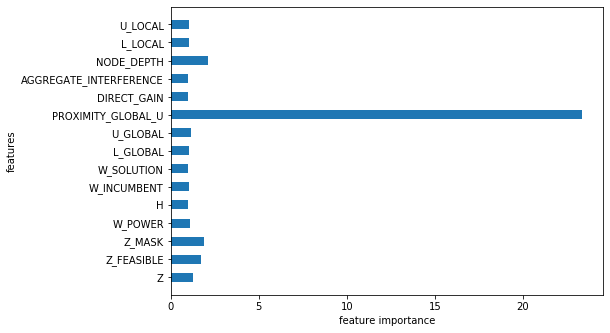

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
keys = [key for key in feature_importance]
values = [feature_importance[key] for key in keys]
ax = fig.add_axes([0,0,1,1])
ax.barh(keys, values, 0.5)
ax.set_xlabel('feature importance')
ax.set_ylabel('features')
plt.show()

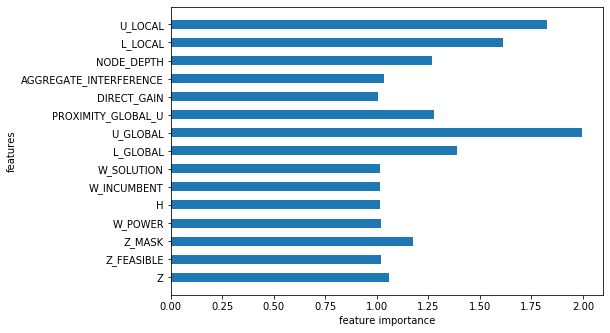

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure()
keys = [key for key in feature_importance]
values = [feature_importance[key] for key in keys]
ax = fig.add_axes([0,0,1,1])
ax.barh(keys, values, 0.5)
ax.set_xlabel('feature importance')
ax.set_ylabel('features')
plt.show()

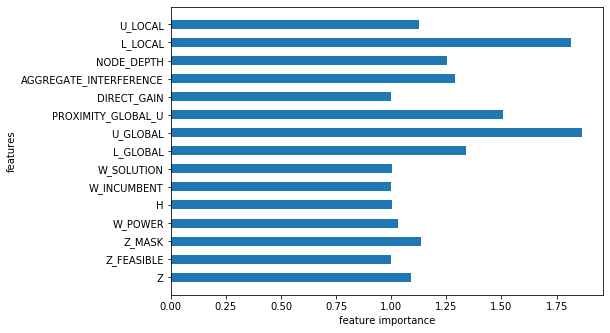

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure()
keys = [key for key in feature_importance]
values = [feature_importance[key] for key in keys]
ax = fig.add_axes([0,0,1,1])
ax.barh(keys, values, 0.5)
ax.set_xlabel('feature importance')
ax.set_ylabel('features')
plt.show()

In [21]:
fig.savefig('feats_imp_corrected.pdf')

In [1]:
import numpy as np
a = np.random.randn(4)

np.argmax(a)

3

In [1]:
print('here')

here


In [23]:
print('{:>.5f}, {:<12}, {:<12}'.format(1/3, 0.4, 44))

0.33333, 0.4         , 44          


In [4]:
print(results['true'])

(tensor(0.6226), tensor(0.9781), 0.8048475278654132, 0.8048475278654132, tensor([[396, 271],
        [ 10, 447]]))


TypeError: 'int' object is not iterable

In [60]:
resurun_validation(valid_loader, policy)

tensor([[  0, 127],
        [  0,  44]])
Valid: precision:0.2573099434375763, recall:1.0, f1-score:0.40930232405662537, loss: 1.3355382680892944, acc: 0.4604966640472412


In [58]:
def run_validation(valid_loader, policy):
    valid_mean_loss = 0
    valid_mean_acc = 0
    n_samples_processed = 0
    targets_list = torch.Tensor([]).to(DEVICE)
    preds_list = torch.Tensor([]).to(DEVICE)
    for batch_data in (valid_loader):
        batch, target = batch_data
        batch = batch.to(DEVICE)
        target = target.to(DEVICE)*1

        if policy_type == 'gnn':
            batch_size = batch.num_graphs
            num_vars = int(batch.variable_features.shape[0]/batch_size)
            wts = torch.tensor([batch.variable_features[i*num_vars, NODE_DEPTH_INDEX] for i in range(batch_size)], dtype=torch.float32)
        else:
            batch_size = batch.shape[0] 
            wts = batch[:,-25]

        wts = 3/wts
        wts = wts.to(DEVICE)

        wts = ((target)*CLASS_IMBALANCE_WT + 1)*wts                   
        out = policy(batch, batch_size)
        bce = nn.BCELoss(weight=wts)   

        try:
            F_w = bce(out.squeeze(), target.to(torch.float).squeeze())
        except:
            F_w = bce(out, target.to(torch.float))

        predicted_bestindex = (out>0.5)*1
        accuracy = sum(predicted_bestindex.reshape(-1) == target)

        targets_list = torch.cat((targets_list, target))
        preds_list = torch.cat((preds_list, predicted_bestindex))

        valid_mean_loss += loss.item() * batch_size
        valid_mean_acc += float(accuracy)
        n_samples_processed += batch_size
    total_data = n_samples_processed
    stacked = torch.stack((targets_list, preds_list.squeeze()), dim=1).to(torch.int)
    cmt = torch.zeros(2,2,dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
        cmt[tl, pl] = cmt[tl, pl] + 1
    print(cmt)
    precision = cmt[1,1]/(cmt[0,1]+cmt[1,1])
    recall = cmt[1,1]/(cmt[1,0]+cmt[1,1])

    valid_fpr = cmt[0,1]/(cmt[0,0] + cmt[0,1])
    valid_fnr = cmt[1,0]/(cmt[1,0] + cmt[1,1])

    valid_mean_acc = 2*(precision*recall)/(precision+recall)
    valid_mean_loss /= n_samples_processed

    valid_loss = mean_loss
    valid_acc = mean_acc

    print("Valid: precision:{}, recall:{}, f1-score:{}, loss: {}, acc: {}".format(precision, recall, valid_mean_acc, valid_mean_loss, valid_acc))
    return precision, recall, loss, acc
    

In [34]:
from models.gnn_dataset import GraphNodeDatasetFromBipartiteNode

class RandomizedDataset:
    def __init__(self, dataset):
        self.original_dataset = dataset
    
    def randomize_feature(self, feature_name='antenna', feature_indices=[]):
        """
        feature_name = one of 'antenna', 'user', or 'edge'
        feature_index = index of the feature 
        """
        
        assert len(feature_indices)>0, "Feature index should be provided"

        nodes = []
        rand_perm = np.random.permutation(len(self.original_dataset))
        
        try:
            for i in range(len(self.original_dataset)):
                new_node = (self.original_dataset[i][0].copy(), self.original_dataset[i][1])
                for feature_index in feature_indices:
                    if feature_name == 'antenna':
                        new_node[0].antenna_features[:,feature_index] = self.original_dataset[rand_perm[i]][0].antenna_features[:, feature_index].clone()

                    elif feature_name == 'user':
                        new_node[0].variable_features[:, feature_index] = self.original_dataset[rand_perm[i]][0].variable_features[:, feature_index].clone()                
                    elif feature_name == 'edge':
                        new_node[0].edge_attr[:, feature_index] = self.original_dataset[rand_perm[i]][0].edge_attr[:, feature_index].clone()

                    nodes.append(new_node)
        except IndexError as e:
            print(e)
            print('Index of feaure {} is out of bounds for indices {}'.format(feature_name, feature_indices))
        return GraphNodeDatasetFromBipartiteNode(nodes)
                

In [36]:
ins = RandomizedDataset(train_data)
random_data = ins.randomize_feature(feature_name='antenna', feature_indices=[1,2])

In [49]:
train_data[0][0].edge_attr.shape

torch.Size([32, 9])

In [56]:

feature_map = {
                'Z_SOL' : (0, 0),
                'Z_FEAS' : (0, 1),
                'Z_MASK' : (0, 2),
                'H' : (1, [0,1,2]),
                'W_INCUMBENT' : (1, [3,4,5]),
                'W_SOL' : (1, [6,7,8]),
                'L_GLOBAL' : (2, 0),
                'U_GLOBAL' : (2, 1),
                'PROXIMITY_GLOBAL' : (2, 2),
                'DIRECT' : (2, 3),
                'INTERFERENCE' : (2,4),
                'DEPTH' : (2,5),
}


feature_names = ['antenna', 'edge', 'user']
feature_sizes = [9, 3, 6]

results = {}

ins = RandomizedDataset(valid_data)
for key in feature_map:
    feauture_name = feature_names[feature_map[key][0]]
    feaure_indices = list(feature_map[key][1])
    random_dataset = ins.randomize_feature(feature_name=feature_name , feature_indices=feature_indices)
    random_dataloader = DataLoader(random_dataset, batch_size=128, shuffle=True)


Z_SOL
Z_FEAS
Z_MASK
H
W_INCUMBENT
W_SOL
L_GLOBAL
U_GLOBAL
PROXIMITY_GLOBAL
DIRECT
INTERFERENCE
DEPTH


In [54]:
feature_map

{'Z_SOL': (0, 0),
 'Z_FEAS': (0, 1),
 'Z_MASK': (0, 2),
 'H': (1, [0, 1, 2]),
 'W_INCUMBENT': (1, [3, 4, 5]),
 'W_SOL': (1, [6, 7, 8]),
 'L_GLOBAL': (2, 0),
 'U_GLOBAL': (2, 1),
 'PROXIMITY_GLOBAL': (2, 2),
 'DIRECT': (2, 3),
 'INTERFERENCE': (2, 4),
 'DEPTH': (2, 5)}

In [2]:
import numpy as np
import cvxpy as cp

a = np.random.randn(5)

In [4]:
a[0] = np.nan

In [5]:
a

array([        nan, -0.72125664, -0.25328187,  0.8545804 , -0.0061516 ])

In [16]:
np.isnan(a[1])

False

In [13]:
a[0] == a[0]

False

In [51]:
list([2, 3])

[2, 3]

In [9]:
np.random.permutation(5)

array([2, 0, 3, 4, 1])

In [3]:
valid_data[0]

(BipartiteNodeData(antenna_features=[6, 13], edge_index=[2, 72], edge_attr=[72, 3], variable_features=[12, 10], candidates=[3], nb_candidates=3, candidate_choices=1, num_nodes=18),
 False)

In [11]:
valid_data[0][0].antenna_features.clone() 

tensor([[-0.0000, -0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.1882, -0.2605,  0.3214],
        [ 1.0000,  1.0000,  1.0000,  0.0000, -0.7124, -0.1473,  0.7274, -1.3837,
         -0.2861,  1.4130,  0.0000,  0.0000,  0.0000],
        [ 1.0000,  1.0000,  1.0000,  0.0000, -0.8873,  0.3181,  0.9426, -1.7236,
          0.6179,  1.8310,  1.1616, -0.0758,  1.1641],
        [-0.0000, -0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0000, -0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000]])